# Building NLP Applications with Hugging Face

Welcome! In this project,  we'll explore various natural language processing (NLP) tasks using the Hugging Face Transformers library and the Sentence Transformers library. We'll work with a dataset containing customer reviews and perform tasks such as:
- **sentiment analysis** (categorizing text as negative or positive);
- **text embedding** (transforming a piece of text into a numerical, n-dimensional vector, representation);
- **semantic search** (matching a query with the most appropriate result based on embeddings);

The dataset comes from "Rent the Runway" [link](https://cseweb.ucsd.edu//~jmcauley/datasets.html#clothing_fit) and is comprised of user reviews on clothing items, their ratings on fit, and other metadata about the user.

## Task 0: Setup

For this project, we will need several Python packages:
- `pandas` for data manipulation and analysis
- `numpy` for numerical operations
- `datetime`, `re`, `string` for regular expressions, date handling, and string operations
- `matplotlib.pyplot` & `seaborn` for data visualization
- `pipeline`  library for using pre-trained Transformer models
- `transformers` & `sentence_transformers` library for generating sentence embeddings
- `semantic_search` for performing semantic search
- `display` and `Markdown` for displaying Markdown output

In [1]:
# Import the other required packages and modules.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re, datetime, string
from transformers import pipeline
from sentence_transformers import SentenceTransformer
from sentence_transformers.util import semantic_search
from IPython.display import display, Markdown

## Task 1: Import the Runway Data

The runway data is contained in a CSV file named `runway.csv`.
The parse_dates parameter is used to specify that the "review_date" column should be parsed as datetime objects.

The dataset contains the following columns.
- `user_id`: the unique identifier for the user.
- `item_id`: the unique identifier for the item/product rented.
- `rating`: the rating by the user.
- `rented_for`: the reason the item was rented.
- `review_text`: the actual text for the submitted user review.
- `category`: the category of the item rented.
- `height`: the height of the user in the format {feet}'{inches}".
- `size`: the size of the item rented by the user.
- `age`: the age of the user.
- `review_date`: the date the review was made by the user.

In [2]:
# Read the data from runway.csv
runway = pd.read_csv("runway.csv", parse_dates=["review_date"])
runway.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1506 entries, 0 to 1505
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      1506 non-null   int64         
 1   item_id      1506 non-null   int64         
 2   rating       1506 non-null   int64         
 3   rented for   1506 non-null   object        
 4   review_text  1506 non-null   object        
 5   category     1506 non-null   object        
 6   height       1503 non-null   object        
 7   size         1506 non-null   int64         
 8   age          1500 non-null   float64       
 9   review_date  1506 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(4), object(4)
memory usage: 117.8+ KB


## Task 2: Preprocessing the `review_text`

Most unstructured text, such as reviews for products, are messy. They contain special characters which may not be necessary, extra spaces, irrelevant digits, and more. Therefore, it is common practice to process, or clean, the text before performing NLP tasks on it.

In [3]:
# Remove the forward-slash character
runway['review_text_cleaned'] = runway['review_text'].str.replace(r"\/", "")

# Remove punctuation
runway['review_text_cleaned']= runway['review_text_cleaned'].str.translate(string.punctuation)

# Remove digits
runway['review_text_cleaned'] = runway['review_text_cleaned'].str.replace(r"\d+", "")

# Remove running spaces
runway['review_text_cleaned'] = runway['review_text_cleaned'].str.replace(r"\s{2,}", "")

# Make the text lowercase
runway['review_text_cleaned'] = runway['review_text_cleaned'].str.lower()

In [4]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.16.0-rc0


## Task 3: Sentiment Analysis on `review_text_cleaned`

We will start with sentiment analysis, the categorizing of text into two buckets - negative or positive.

In this task, we will use the `pipeline()` function with the ["distilbert-base-uncased-finetuned-sst-2-english"](https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english) model. 
This is a smaller general-purpose language representation model that is great at text classification.

In [5]:
model = "distilbert-base-uncased-finetuned-sst-2-english"

sentimentAnalysis = pipeline("sentiment-analysis", model=model)

sent_analysis_output = sentimentAnalysis(list(runway['review_text_cleaned']))

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

## Task 4: Histogram of Sentiment Score

Now, the distribution of the sentiment of review texts via a histogram. This will give an overall understanding of the reviews specifically how customers viewed their rented items.

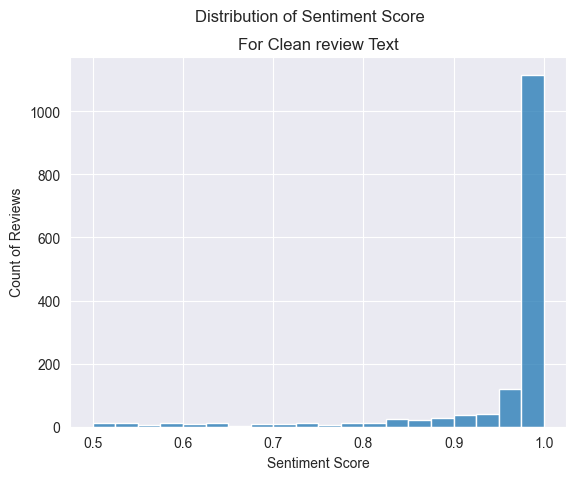

In [6]:
# Parse out the two pieces of output from sent_analysis_output - "label" and "score".
runway["clean_sentiment_category"] = [s['label'] for s in sent_analysis_output]
runway["clean_sentiment_score"] = [s['score'] for s in sent_analysis_output]

# Create the first histogram using the built
sns.histplot(data=runway, x = "clean_sentiment_score", bins=20)
plt.suptitle("Distribution of Sentiment Score")
plt.xlabel("Sentiment Score")
plt.ylabel("Count of Reviews")
plt.title("For Clean review Text")
plt.show()

## Task 5: Sentiment Over the Years

Now, we can explore the trends of sentiment across different facets of the data (over time, between products). It will explain more about what is going well and what needs improvement.

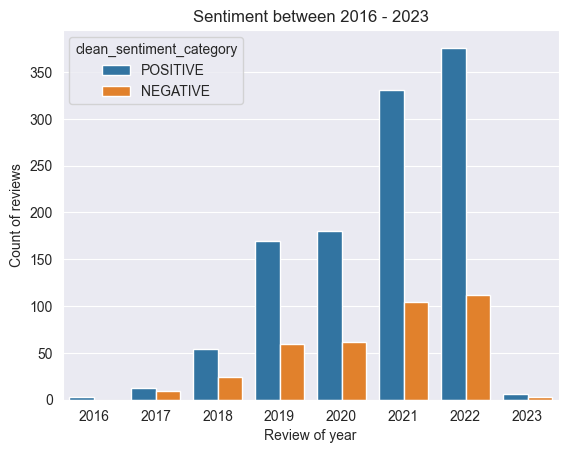

In [7]:
# Create a new column called "year" of the "review_date".
runway['year'] = runway['review_date'].dt.year

# Create a new dataframe of review counts by "year" and "cleaned_sentiment_category".
chart_data  = runway.groupby(['year', 'clean_sentiment_category'], as_index=False)['user_id'].count() 
chart_data.columns = ['year', 'clean_sentiment_category', 'cnt']

# Create a bar plot showing the count of reviews for each sentiment category over the years.
sns.barplot(data=chart_data, x="year", y="cnt", hue="clean_sentiment_category")
plt.title("Sentiment between 2016 - 2023")
plt.xlabel("Review of year")
plt.ylabel("Count of reviews")
plt.show()

## Task 6: Does Cleaning Text Matter?

In this task, we will build another sentiment analysis pipeline but, in this case, for the non-cleaned `review_text`. Then, we will compare the output from the two pipelines to understand if the cleaning made a difference in categorizing sentiment.

In [8]:
# Create a new sentiment analysis output for "review_text".
sent_analysis_2 = sentimentAnalysis(list(runway['review_text']))

# Parse the output into "sentiment_category" and "sentiment_score".
runway["sentiment_category"] = [s['label'] for s in sent_analysis_2]
runway["sentiment_score"] = [s['score'] for s in sent_analysis_2]


# Print the confusion matrix comparing the two sentiment category outputs.
display(pd.crosstab(runway['clean_sentiment_category'], runway['sentiment_category']))

sentiment_category,NEGATIVE,POSITIVE
clean_sentiment_category,,
NEGATIVE,373,1
POSITIVE,2,1130


Here, we print a confusion matrix comparing the "clean_sentiment_category" (sentiment category of the cleaned text) and "sentiment_category" (sentiment category of the original text) columns. The pd.crosstab function from pandas is used to create a cross-tabulation of the two columns, which represents the confusion matrix.

## Task 7: Embeddings

In the next task, we will switch gears to exploring another common use case for Hugging Face and transformers - text embeddings. 

Embeddings, in a very simplistic definition, are a vector (numerical) representation of something within n-dimensions. In this case, they are text embeddings. (Note: each transformer model will have a different number of dimensions for its results). Embeddings are useful because they represent human language to computers which enables a more sophisticated execution of similarity, text generation, semantic search, and the like. This can be extremely valuable for business tasks such as recommendations and searching within websites or products.

We will now try this out on the `rented for` column using the `sentence_transformer` [package](https://huggingface.co/sentence-transformers). The model we'll use is the BERT-based ["all-MiniLM-L6-v2" model](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2) which transformer that maps sentences and paragraphs to an n-dimensional vector.

In [9]:
model_id = "sentence-transformers/all-MiniLM-L6-v2"

# Instantiate a new SentenceTransformer object.
model = SentenceTransformer(model_id)

# Generate the embeddings for the "rented for" column.
embeddings = model.encode(list(runway['rented for']))
embeddings.shape


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

(1506, 384)

## Task 8: Clustering

In this section, we visualize the generated embeddings using the t-SNE (t-Distributed Stochastic Neighbor Embedding) technique. We first import the TSNE module from scikit-learn and instantiate a new TSNE object with specific parameters. We then apply TSNE to the generated embeddings to reduce their dimensionality to 2D.



In [10]:
# Import TSNE
from sklearn.manifold import TSNE

# Instantiate a new TSNE object. 
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)

# Generate the tsne dimensions using the saved embeddings.
tsne_dims = tsne.fit_transform(embeddings)

print(tsne_dims.shape)

(1506, 2)


## Task 9: Visualizing the Clusters

With these smaller vectors, let's move on to generating basic clusters (the average of each category) and building a visualization for them!

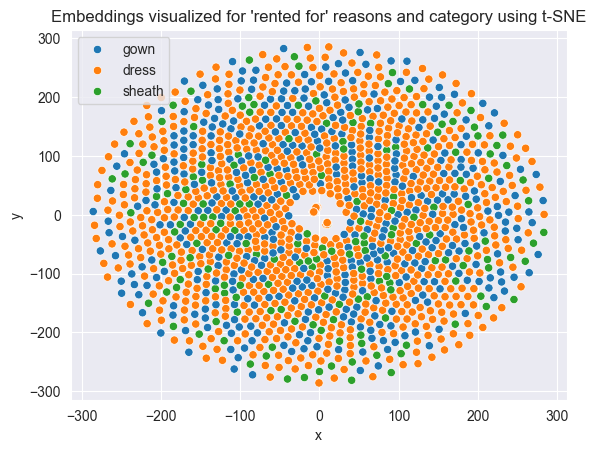

In [11]:
runway['x'] = [x for x, y in tsne_dims]
runway['y'] = [y for x, y in tsne_dims]

# Create the scatterplot
sns.scatterplot(x = "x", y = "y", hue = "category", data = runway)
plt.legend() 
plt.title("Embeddings visualized for 'rented for' reasons and category using t-SNE")
plt.show()

## Task 10: Semantic Search

The plot is showing us all of the review embeddings - based on the "rented_for" column - in a two-dimensional space. The color is indicating the type of item rented, i.e. "dress", "gown", "sheath".

There are clearly two main clusters in this dataset for "rented for" - the mainly blue cluster and the mainly orange one. The blue cluster consists primarily of gowns while the other is mainly dresses.

Semantic search denotes "searching with meaning" and with context when available. The goal is to infer what the user's intent is then find the most relevant results.

In [12]:
# Define query
query = "a gorgeous and flattering dress"

# Embed query
query_emb = model.encode(query, convert_to_tensor=True)

# Calculate similarity between query and item embeddings
hits = semantic_search(query_emb, embeddings, top_k=3)

# Print top similar items
for hit in hits [0]:
    idx = hit['corpus_id']
    print(
        "ITEM ID: ", runway.iloc[idx]['item_id'],
        "; RENTED FOR: ", runway.iloc[idx]['rented for'],
        "; REVIEW: ", runway.iloc[idx]['review_text']
    )

ITEM ID:  652189 ; RENTED FOR:  wedding ; REVIEW:  even though it was lined with satin this was a light beachy dress that was still formal enough for this casual beach weddingitsbackless though so you cant wear a bra and because the neck is such a scoopneck it makes the neckline a little strange if you have a chest and dont wear onei ended up getting one of those stick on bras and the dress looked much betterits much pinker than the model picture which was a pleasant surprisepretty dress comfortable just a little awkward fitting in the chest area if you have anything larger than an abuy the stick on bra
ITEM ID:  1498329 ; RENTED FOR:  wedding ; REVIEW:  the dress was gorgeous but unfortunately i was unable to wear it due to some quality issues which the renttherunway team was excellent at handlingi would recommend going upsizes from your usual dress size if you have a larger bustit also runs on the long side imand even withinch heels it dragged a little too much for my preferencethe c

## Task 11: Generate New Marketing Material

The semantic search returned three different items that appear to be similar to what we were searching for, i.e. "the dress was gorgeous" and "this dress was a great fit". 

Let's generate some new text based on a prompt. Specifically, creating some brainstorming material for a new marketing campaign. 

In [13]:
# Instantiate the pipeline for generating text
generator = pipeline(model="gpt2")

# Pre-defined prompt
prompt = "New for this winter season, a lovely dress that"

# Use the prompt as input to the generator to return output.
output = generator(prompt, num_return_sequences = 1, return_full_text=False)

# Print the generated text.
print("New Marketing Campaign: ", prompt, output[0]['generated_text'])


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


New Marketing Campaign:  New for this winter season, a lovely dress that 's always great when you don't have to wear it.

1. The Winter Dress!

We love this one; the lace, sequined waistband and long sleeves at the front
